In [1]:
from queries import *
from datetime import date
import matplotlib.pyplot as plt
import numpy as np

from plotting_citation_trajectories import plot_citation_trajectory

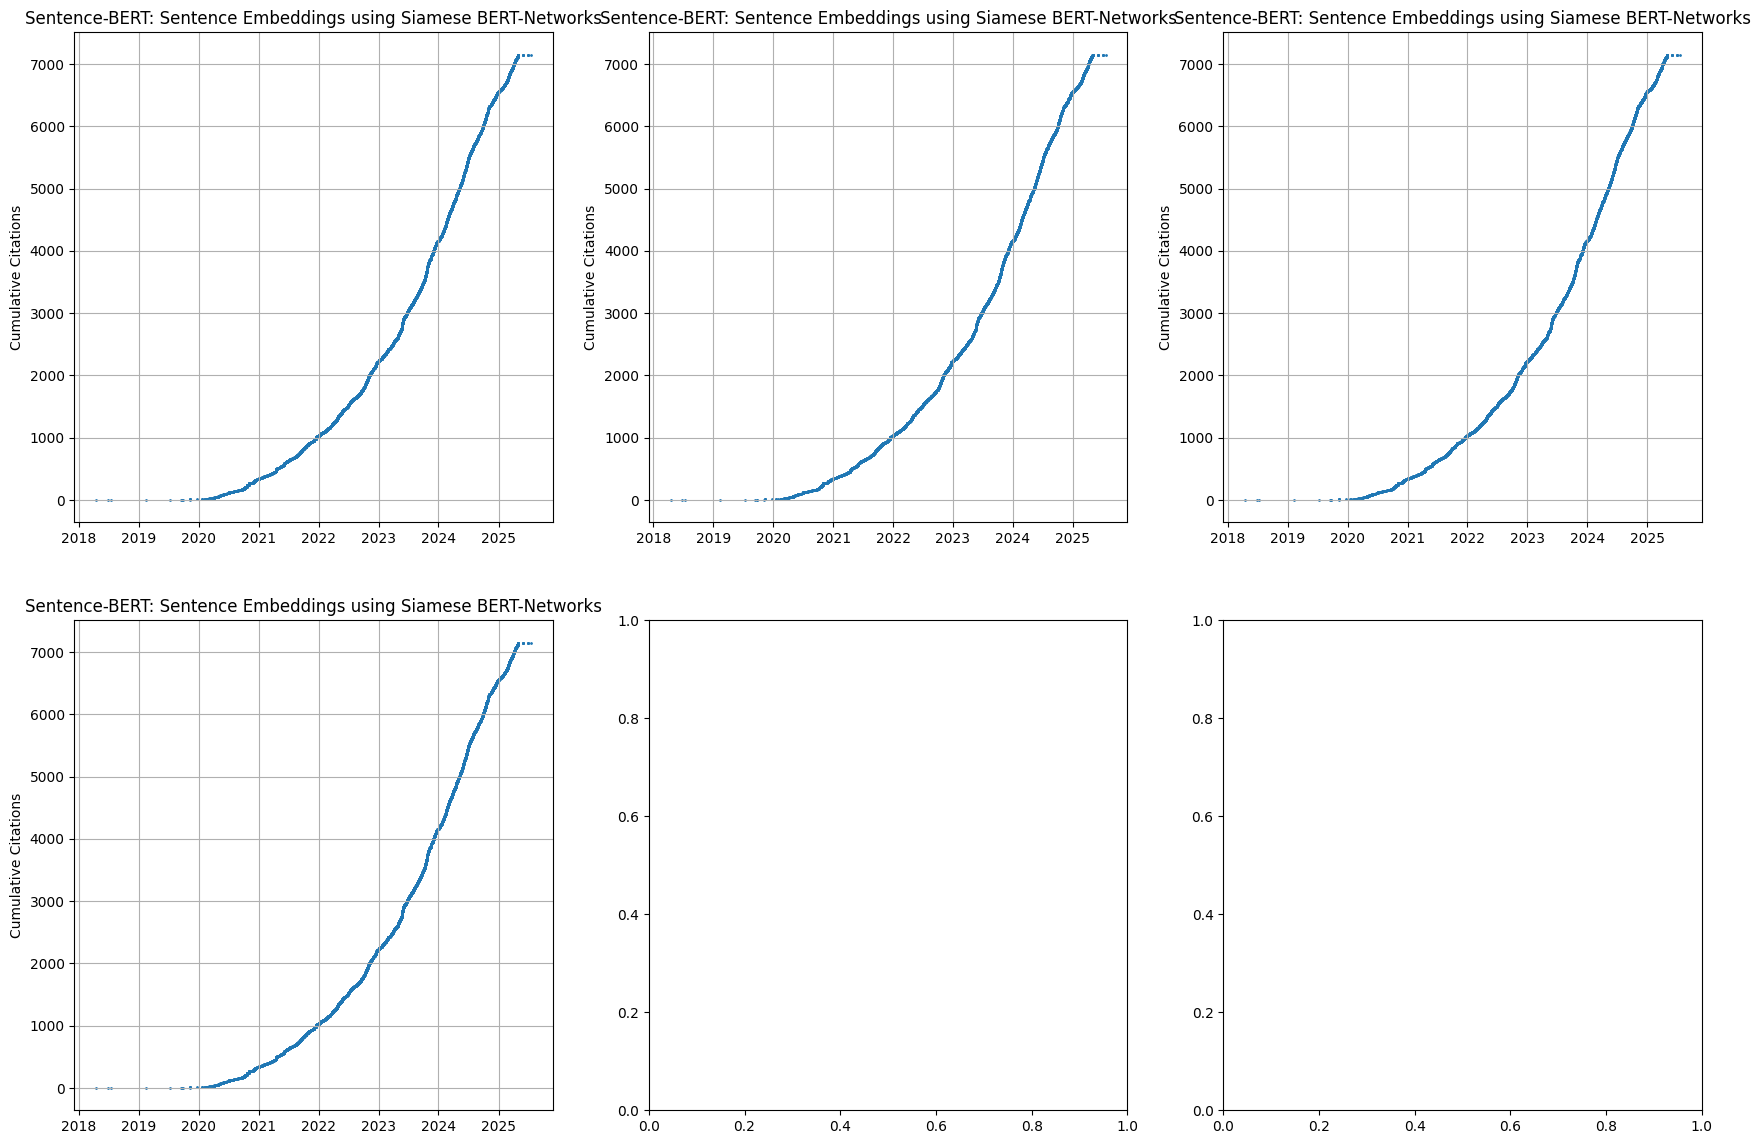

In [8]:

target_corpus_id = 201646309
fig, ax = plt.subplots(2,3, figsize=(21, 14))
plot_citation_trajectory(ax[0,0], target_corpus_id)
plot_citation_trajectory(ax[0,1], target_corpus_id)
plot_citation_trajectory(ax[0,2], target_corpus_id)
plot_citation_trajectory(ax[1,0], target_corpus_id)